# Random Forest Model the UNSW-NB15 Dataset


In [1]:
# Core data manipulation and analysis libraries
import pandas as pd  # type: ignore # For data manipulation and analysis
import numpy as np   # type: ignore # For numerical operations and arrays

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder # type: ignore

from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.metrics import ( # type: ignore
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    mean_squared_error,
    r2_score
)

from sklearn.pipeline import Pipeline # type: ignore

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

import os
import pickle
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import shap # type: ignore


**Load the Splitted Dataset.**



In [2]:
# Function to load data from a pickle file
def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

output_folder = 'C:/Users/raman/OneDrive/Important/1UnisaSTUDY/Courses/Capstone_Project_1/Github/Code Working/Pickle'  # Change to desired folder in your Computer

X_train = load_pickle_file(os.path.join(output_folder, 'X_train.pkl'))
X_test = load_pickle_file(os.path.join(output_folder, 'X_test.pkl'))
y_train = load_pickle_file(os.path.join(output_folder, 'y_train.pkl'))
y_test = load_pickle_file(os.path.join(output_folder, 'y_test.pkl'))

print("Data loaded from pickle files.")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print(f"Training set size: {y_train.shape}")
print(f"Test set size: {y_test.shape}")

print("\nTraining set head (features):")
print(X_train.head())
print("\nTraining set head (labels):")
print(y_train.head())

print("\nTest set head (features):")
print(X_test.head())
print("\nTest set head (labels):")
print(y_test.head())

Data loaded from pickle files.
Training set size: (2032037, 48)
Test set size: (508010, 48)
Training set size: (2032037,)
Test set size: (508010,)

Training set head (features):
         srcip  sport  dstip  dsport  proto  state       dur    sbytes  \
596843      38  49373     27   54769    114      5 -0.046008 -0.031869   
593275      42  30709     25   37620    114      5 -0.045501 -0.012864   
1254949     35  42244     26   35345    114      5 -0.046083 -0.028181   
191973      34  42875     21   51807    120      2 -0.047183 -0.067574   
2185322     35  38677     21   51652    114      5 -0.046969 -0.011694   

           dbytes      sttl  ...  is_ftp_login  ct_ftp_cmd  ct_srv_src  \
596843  -0.080670 -0.425902  ...     -0.132116   -0.170489   -0.203658   
593275   0.058514 -0.425902  ...     -0.132116   -0.170489   -0.203658   
1254949 -0.054673 -0.425902  ...     -0.132116         NaN   -0.665051   
191973  -0.224236 -0.425902  ...     -0.132116   -0.170489    0.534571   
2185322

Reduce size to smaller value for Dataset

In [3]:

# Convert y_train and y_test to pandas Series if they are not already
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train)
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# Reset indices to avoid index mismatch
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Sample data for faster run time
X_train_sampled = X_train.sample(n=1000, random_state=123)
X_test_sampled = X_test.sample(n=1000, random_state=123)
y_train_sampled = y_train.iloc[X_train_sampled.index]
y_test_sampled = y_test.iloc[X_test_sampled.index]

# Print shapes of sampled datasets
print(f"Sampled training set size: {X_train_sampled.shape}")
print(f"Sampled test set size: {X_test_sampled.shape}")

# Print sizes to verify they match
print(f"\nNumber of samples:")
print(f"X_train samples: {len(X_train_sampled)}")
print(f"y_train samples: {len(y_train_sampled)}")
print(f"X_test samples: {len(X_test_sampled)}")
print(f"y_test samples: {len(y_test_sampled)}")

# Verify matching dimensions
print(f"\nDimension check:")
print(f"X_train and y_train match: {len(X_train_sampled) == len(y_train_sampled)}")
print(f"X_test and y_test match: {len(X_test_sampled) == len(y_test_sampled)}")

Sampled training set size: (1000, 48)
Sampled test set size: (1000, 48)

Number of samples:
X_train samples: 1000
y_train samples: 1000
X_test samples: 1000
y_test samples: 1000

Dimension check:
X_train and y_train match: True
X_test and y_test match: True


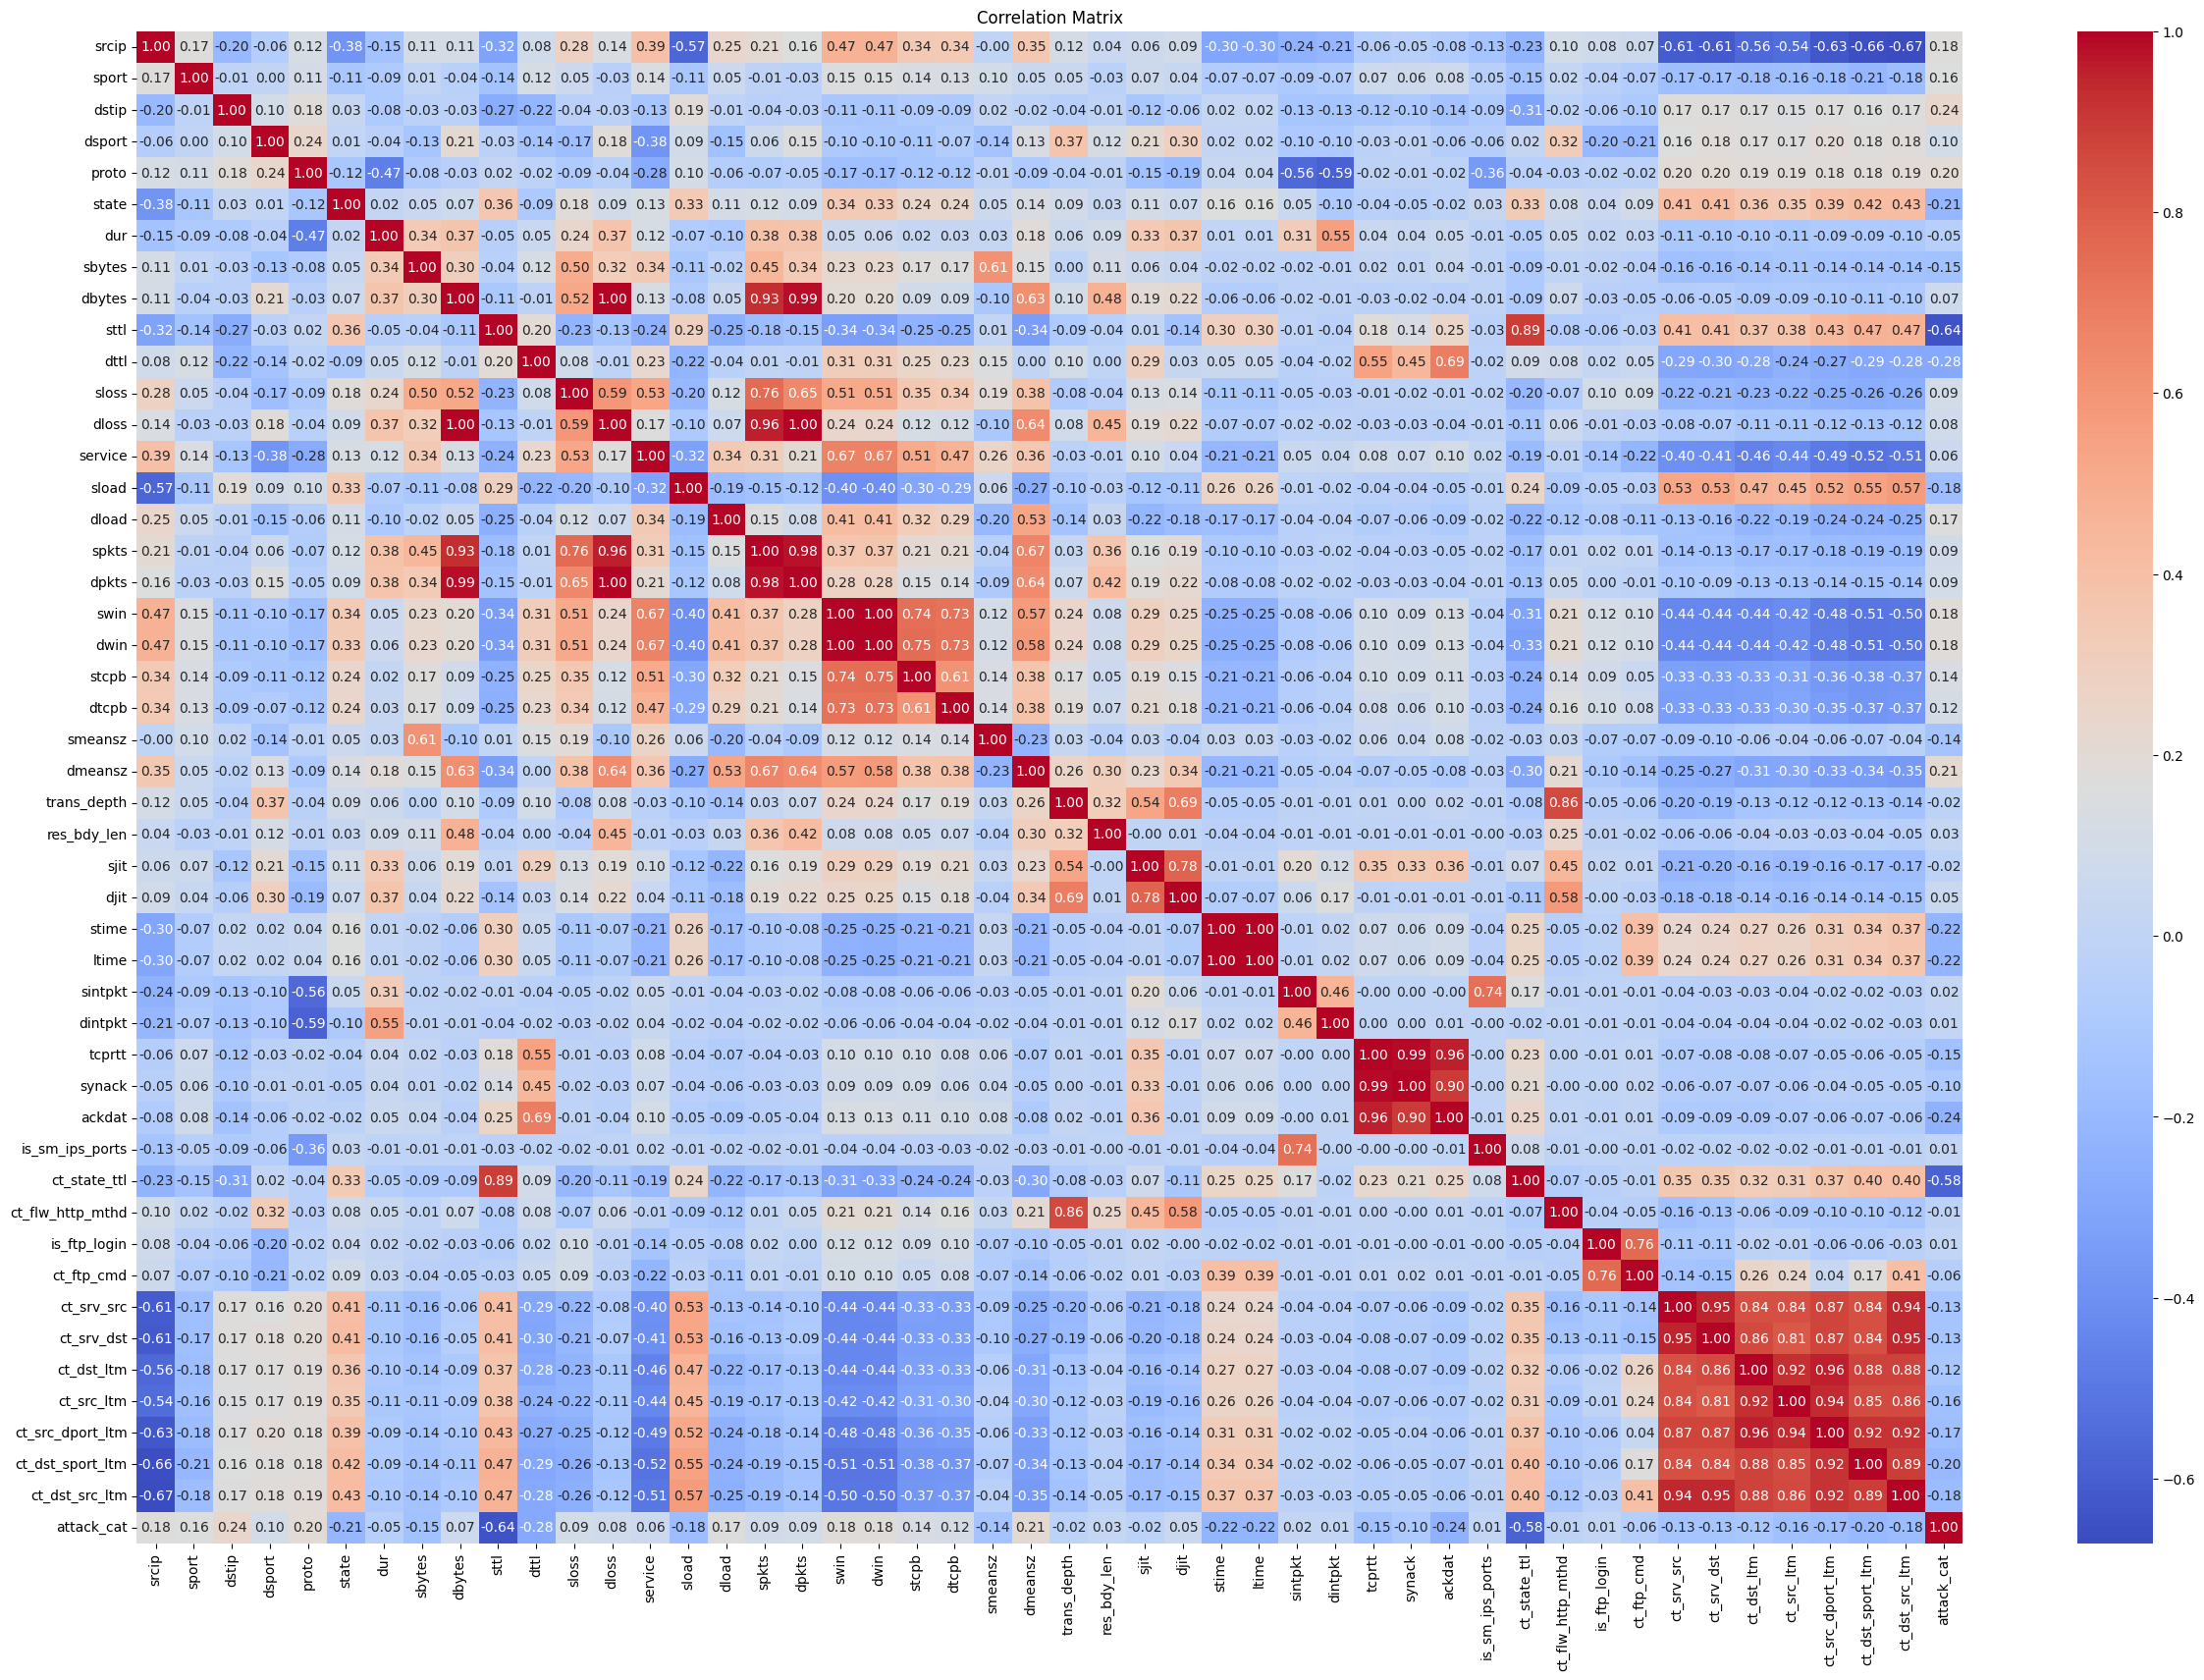

In [4]:
# Calculate correlation matrix
correlation_matrix = X_train_sampled.corr()

# Plot correlation matrix
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Model training complete.
Accuracy: 0.9910

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       871
           1       1.00      0.93      0.96       129

    accuracy                           0.99      1000
   macro avg       0.99      0.97      0.98      1000
weighted avg       0.99      0.99      0.99      1000


Confusion Matrix:
[[871   0]
 [  9 120]]


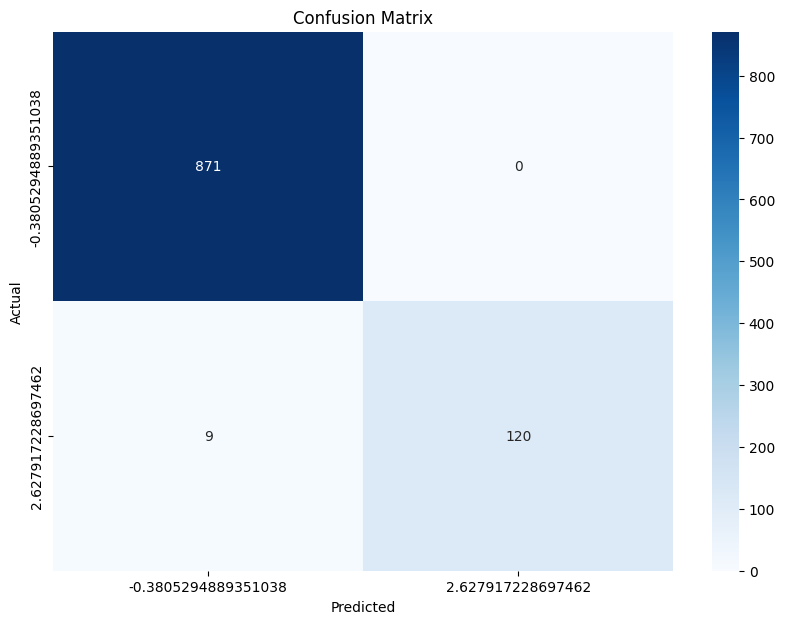

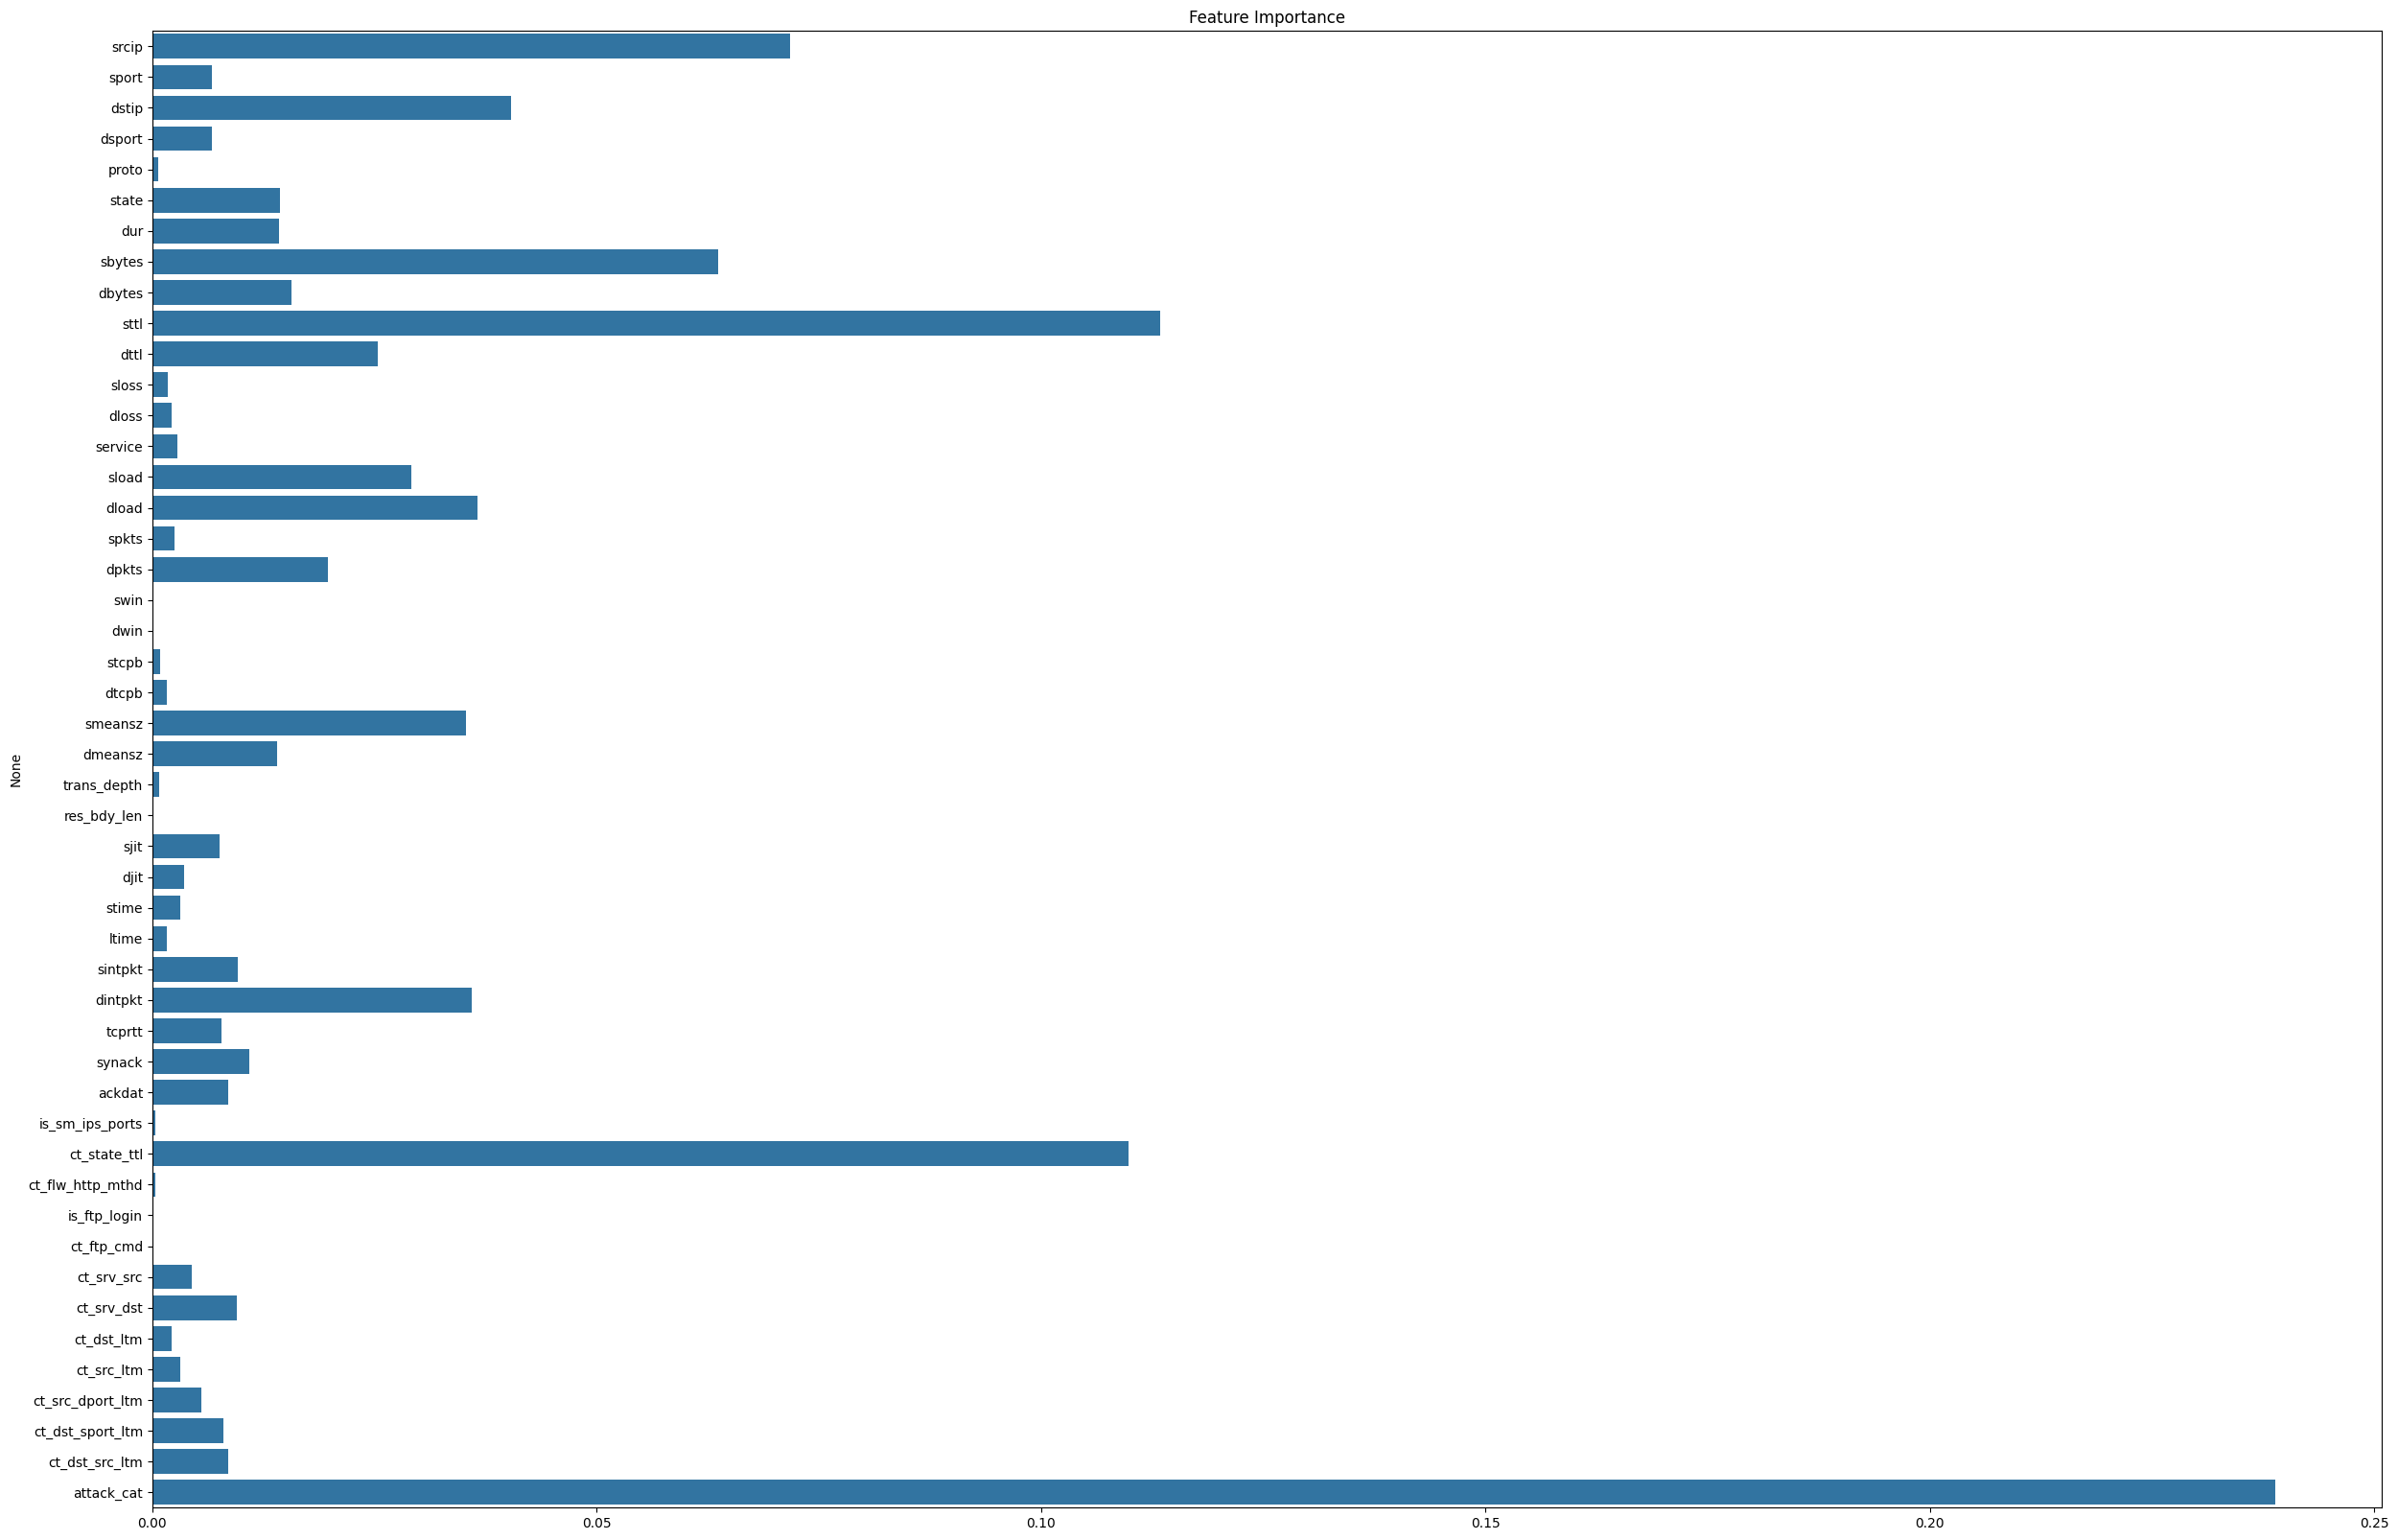

In [5]:
# Convert continuous labels to discrete labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_sampled)
y_test_encoded = le.transform(y_test_sampled)

# Create a RandomForest model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,random_state=42))  # RandomForest classifier
])

# Train the model
pipeline.fit(X_train_sampled, y_train_encoded)
print("Model training complete.")

# Make predictions
y_pred = pipeline.predict(X_test_sampled)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
model = pipeline.named_steps['classifier']
feature_importances = model.feature_importances_
features = X_train_sampled.columns

plt.figure(figsize=(30, 20))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

In [6]:
# Save the trained model to a pickle file
model_path = os.path.join(output_folder, 'random_forest_model_1000.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"Trained model saved to {model_path}.")

Trained model saved to C:/Users/raman/OneDrive/Important/1UnisaSTUDY/Courses/Capstone_Project_1/Github/Code Working/Pickle\random_forest_model_1000.pkl.


In [7]:
# Generating SHAP explanations:
# - Initializes JavaScript visualization with shap.initjs()
# - Creates SHAP explainer using the model and training data
# - Calculates SHAP values for test data
# - Generates force plot visualization
# Note: Make sure X_train_sampled and X_test_sampled contain balanced samples
shap.initjs()

# explain all the predictions in the test set
#explainer = shap.Explainer(model, X_train_sampled)
#shap_values = explainer.shap_values(X_test_sampled)
#shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_sampled)


In [8]:
from explainerdashboard import  ExplainerDashboard,ClassifierExplainer # type: ignore

# Create and run dashboard
explainer = ClassifierExplainer(pipeline.named_steps['classifier'], X_train_sampled, y_train_encoded)
dashboard = ExplainerDashboard(explainer)

# Save the dashboard as HTML
dashboard.save_html("UNSW-NB-15_RandomFroest_1000_samples.html")

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will s

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without 

Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\raman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without 